# 1.Eliminar Mostrar de reacciones, detectar genero, detectar hashtag

In [3]:
import json
import gender_guesser.detector as gender
import re

# Cargar el archivo JSON existente
archivo_json = "DB Original.json"
nuevo_archivo_json = "DB Completo Sin Sentimientos.json"

try:
    # Leer el archivo JSON
    with open(archivo_json, "r", encoding="utf-8") as json_file:
        publicaciones = json.load(json_file)



################################ Procesar cada publicación para limpiar las reacciones
    for publicacion in publicaciones:
        reacciones = publicacion.get("reacciones", {})
        if isinstance(reacciones, dict):  # Validar que es un diccionario
            reacciones_limpias = {}
            for tipo_reaccion, valor in reacciones.items():
                if isinstance(valor, str) and "Mostrar" in valor:  # Procesar solo si contiene "Mostrar"
                    numero = "".join(filter(str.isdigit, valor))
                    reacciones_limpias[tipo_reaccion] = int(numero) if numero.isdigit() else 0
                else:
                    # Mantener el valor original si no contiene "Mostrar"
                    reacciones_limpias[tipo_reaccion] = valor
            # Reemplazar las reacciones con las versiones limpias
            publicacion["reacciones"] = reacciones_limpias
        else:
            publicacion["reacciones"] = {}

######################################## Procesar cada publicación para extraer hashtags
    for publicacion in publicaciones:
        titulo = publicacion.get("titulo", "")
        if isinstance(titulo, str):  # Validar que el título es un string
            hashtags = re.findall(r"#\w+", titulo)
            publicacion["hashtags"] = hashtags
        else:
            publicacion["hashtags"] = []

#################################################### Inicializar el detector de género
    detector = gender.Detector()

    # Procesar cada comentario en las publicaciones
    for publicacion in publicaciones:
        comentarios = publicacion.get("comentarios", [])
        if isinstance(comentarios, list):  # Validar que los comentarios son una lista
            for comentario in comentarios:
                usuario = comentario.get("usuario", "")
                if isinstance(usuario, str) and usuario:
                    # Separar el nombre completo en partes
                    partes = usuario.split()

                    # Evaluar el género basado en los primeros dos nombres
                    genero_principal = detector.get_gender(partes[0]) if len(partes) > 0 else "unknown"
                    genero_secundario = detector.get_gender(partes[1]) if len(partes) > 1 else "unknown"

                    # Decidir el género final basado en los dos primeros nombres
                    if genero_principal in ['male', 'mostly_male'] or genero_secundario in ['male', 'mostly_male']:
                        comentario["genero"] = "Masculino"
                    elif genero_principal in ['female', 'mostly_female'] or genero_secundario in ['female', 'mostly_female']:
                        comentario["genero"] = "Femenino"
                    else:
                        # Si es indeterminado, intentar con el último "nombre"
                        ultimo_nombre = partes[-1] if partes else ""
                        genero_final = detector.get_gender(ultimo_nombre)
                        if genero_final in ['male', 'mostly_male']:
                            comentario["genero"] = "Masculino"
                        elif genero_final in ['female', 'mostly_female']:
                            comentario["genero"] = "Femenino"
                        else:
                            comentario["genero"] = "Indeterminado"  # Si sigue sin identificarse
                else:
                    comentario["genero"] = "Indeterminado"  # En caso de que no haya usuario
        else:
            publicacion["comentarios"] = []  # Si no es una lista, reemplazar por una lista vacía

    # Guardar el JSON actualizado en un nuevo archivo
    with open(nuevo_archivo_json, "w", encoding="utf-8") as json_file:
        json.dump(publicaciones, json_file, ensure_ascii=False, indent=4)

    print(f"Archivo actualizado con género guardado en los comentarios: '{nuevo_archivo_json}'.")
except Exception as e:
    print(f"Error al procesar el archivo JSON: {e}")



Archivo actualizado con género guardado en los comentarios: 'DB Completo Sin Sentimientos.json'.


## 2.Leer Archivos


In [1]:
import json
import pandas as pd

# Nombre del archivo JSON
archivo_entrada = "DB Completo Sin Sentimientos.json"
archivo_salida = "DB Completo Sin Sentimientos.json"

# Cargar el archivo JSON
try:
    with open(archivo_entrada, "r", encoding="utf-8") as json_file:
        publicaciones = json.load(json_file)
except Exception as e:
    print(f"Error al cargar el archivo JSON: {e}")
    exit()

# Convertir a DataFrame
Datos = pd.json_normalize(
    publicaciones,
    record_path='comentarios',
    meta=['titulo', 'pagina', 'fecha', 'reacciones', 'veces_compartido', 'numero_comentarios', 'hashtags'],
    errors='ignore'
)

if 'numero_comentarios' in Datos.columns:
    Datos['numero_comentarios'] = Datos['numero_comentarios'].apply(
        lambda x: int(x) if str(x).isdigit() else 0  # Si no es un número, reemplaza con 0
    )
else:
    Datos['numero_comentarios'] = 0


In [58]:
print(Datos)

                  usuario                                         comentario  \
0           Sandra Barros                Jajajaja jajajajaja ¿ es en serio??   
1           Diego Herrera  Rompiendo oidos con este tipo de géneros sin s...   
2           James Howlett                                      Que porquer..   
3         Adrian Santiago                                 típicos ignorantes   
4        Brayan Maldonado  Los padres deben de evitar que sus hijos compr...   
...                   ...                                                ...   
15913     Beatriz Andrade           Ella tiene muy buen gusto, él está lindo   
15914      Marlu Gonzalez                                        Ella es fea   
15915   Romny Jesus López  Otra víctima... Está a tiempo de salir huyendo...   
15916         Rocio Lopez                                          Noooooooo   
15917  Nohä Yanet Ramirez                       Otra víctima de su caprichos   

              genero                   

## Duplicar columnas Comentario

In [2]:
# Duplicar la columna 'comentarios' y renombrarla como 'comentarios_tratados'
Datos['comentarios_tratados'] = Datos['comentario']

## Eliminar Nombres Comentarios

In [3]:
import spacy

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_md")
print("Modelo cargado correctamente")

# Función para eliminar nombres de personas
def eliminar_nombres(texto):
    doc = nlp(texto)
    # Reemplazar entidades PERSON por un espacio
    texto_sin_nombres = " ".join([token.text for token in doc if token.ent_type_ != "PER"])
    return texto_sin_nombres

# Aplicar la función a los comentarios
Datos['comentarios_tratados'] = Datos['comentarios_tratados'].apply(eliminar_nombres)


Modelo cargado correctamente


## Eliminar Stopword,Asignar musculas

In [4]:
import nltk
from nltk.corpus import stopwords
import re

# Descargar stopwords de NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Configurar stopwords adicionales
stopwords_generales = set(stopwords.words('spanish'))
stopwords_generales.update(['q', 'sins', 'sins sins'])  # Agregar stopwords personalizadas

# Preprocesar texto: convertir a minúsculas, eliminar caracteres especiales, enlaces y números
def limpiar_texto(texto):
    texto = texto.lower()  # Convertir a minúsculas
    texto = nltk.RegexpTokenizer(r'\w+').tokenize(texto)  # Tokenizar (remueve caracteres especiales)
    texto = [palabra for palabra in texto if palabra not in stopwords_generales]  # Remover stopwords
    return ' '.join(texto)

# Aplicar la función limpiar texto
Datos['comentarios_tratados'] = Datos['comentarios_tratados'].apply(limpiar_texto)

# Eliminar la palabra "seguir"
Datos['comentarios_tratados'] = Datos['comentarios_tratados'].str.replace(r'\bseguir\b', '', regex=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yeider\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yeider\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Grafico palabras mas repetidas


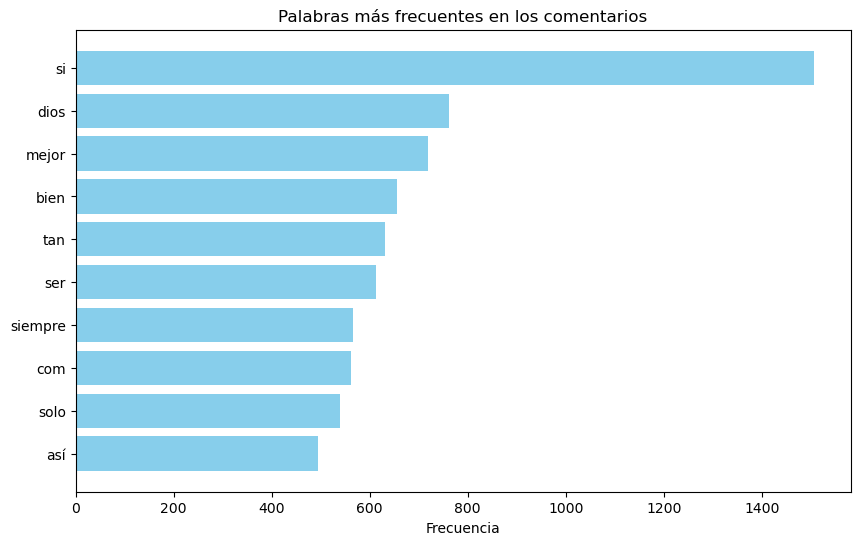

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import re

# Obtener los comentarios
comentarios = Datos['comentarios_tratados'].dropna()  # Eliminar valores NaN

# Convertir todos los comentarios a un solo texto
comentarios_concatenados = ' '.join(comentarios)

# Dividir el texto en palabras
palabras = comentarios_concatenados.split()

# Contar las palabras
frecuencia_palabras = Counter(palabras)

# Obtener las 10 palabras más comunes
palabras_mas_frecuentes = frecuencia_palabras.most_common(10)

# Separar las palabras y sus frecuencias
palabras, frecuencias = zip(*palabras_mas_frecuentes)

# Graficar las palabras más frecuentes
plt.figure(figsize=(10, 6))
plt.barh(palabras, frecuencias, color='skyblue')
plt.xlabel('Frecuencia')
plt.title('Palabras más frecuentes en los comentarios')
plt.gca().invert_yaxis()  # Invertir el eje y para que la palabra más frecuente esté arriba
plt.show()


## Crear ID Publicacion

In [6]:
# Crear una nueva columna "ID_Titulo" basada en los títulos únicos
Datos["ID_Publicacion"] = pd.factorize(Datos["titulo"])[0] + 1  # Sumar 1 para que los IDs comiencen en 1

## Guardar archivo


In [13]:
# Reconstruir la estructura original del JSON
estructura_reconstruida = []

for titulo, grupo in Datos.groupby('titulo'):
    publicacion = {
        "titulo": titulo,
        "comentarios": grupo[['usuario', 'comentario', 'genero', 'comentarios_tratados', 'ID_Publicacion']].to_dict(orient='records') if 'comentario' in Datos.columns else [],
        "pagina": grupo['pagina'].iloc[0] if 'pagina' in Datos.columns else None,
        "fecha": grupo['fecha'].iloc[0] if 'fecha' in Datos.columns else None,
        "reacciones": grupo['reacciones'].iloc[0] if 'reacciones' in Datos.columns else {},
        "veces_compartido": int(grupo['veces_compartido'].iloc[0]) if 'veces_compartido' in Datos.columns else 0,
        "numero_comentarios": int(grupo['numero_comentarios'].iloc[0]) if 'numero_comentarios' in Datos.columns else 0,
        "hashtags": grupo['hashtags'].iloc[0] if 'hashtags' in Datos.columns else ''
    }
    estructura_reconstruida.append(publicacion)

# Guardar el JSON con formato legible
try:
    with open(archivo_salida, 'w', encoding='utf-8') as json_file:
        json.dump(estructura_reconstruida, json_file, ensure_ascii=False, indent=4)
    print(f"Archivo JSON procesado guardado como: {archivo_salida}")
except Exception as e:
    print(f"Error al guardar el archivo JSON: {e}")

Archivo JSON procesado guardado como: DB_Procesado.json
